In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_image(title, image):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def show_image_plt(title, image, cmap = None):
    plt.figure(title)
    plt.imshow(image,cmap=cmap)
    plt.axis('off')
    plt.show()

def cvt_image_colorspace(image, colorspace = cv2.COLOR_BGR2GRAY):
    return cv2.cvtColor(image, colorspace)

def median_filtering(image, kernel_size=3):
    '''

    :param image: grayscale image
    :param kernel_size: kernel size should be odd number
    :return: blurred image
    '''

    return cv2.medianBlur(image, kernel_size)


def apply_threshold(image, **kwargs):
    '''

    :param image: image object
    :param kwargs: threshold parameters - dictionary
    :return:
    '''
    threshold_method = kwargs['threshold_method']
    max_value = kwargs['pixel_value']
    threshold_flag = kwargs.get('threshold_flag', None)
    if threshold_flag is not None:
        ret, thresh1 = cv2.adaptiveThreshold(image, max_value, threshold_method,cv2.THRESH_BINARY, kwargs['block_size'], kwargs['const'])
    else:
        ret, thresh1 = cv2.threshold(image, kwargs['threshold'], max_value, threshold_method)
    return thresh1

def sobel_filter(img,x,y,kernel_size = 3):
    return cv2.Sobel(img, cv2.CV_8U, x,y, ksize=kernel_size)


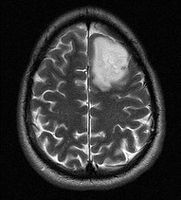

(200, 181, 3)
(20, 18, 3)


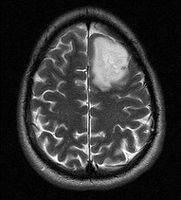

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import sys
##from processing import *


##file = input("Image?: ")
image = cv2.imread('10.jpeg', 1)
cv2_imshow(image)
print(image.shape)
 

##cv2_imshow(half)
#Step one - grayscale the image
grayscale_img = cvt_image_colorspace(image)
half = cv2.resize(image, (0, 0), fx = 0.1, fy = 0.1)
print(half.shape)
cv2_imshow(grayscale_img)
output = image
##hist = cv2.calcHist([image],[0],None,[256],[0,256])
##cv2.applyColorMap(half, output, cv2.COLORMAP_OCEAN)

##cv2_imshow(hist)
##plt.hist(image, clim=(0.0, 0.7))
##plt.show()

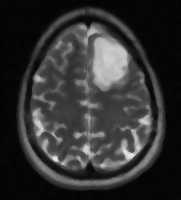

In [ ]:
#Step two - filter out image
median_filtered = median_filtering(grayscale_img,5)
cv2_imshow(median_filtered)

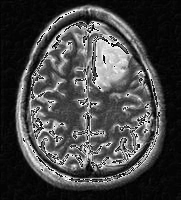

In [ ]:
#testing threshold function
bin_image = apply_threshold(median_filtered,  **{"threshold" : 160,
                                                 "pixel_value" : 255,
                                                 "threshold_method" : cv2.THRESH_BINARY})
otsu_image = apply_threshold(median_filtered, **{"threshold" : 0,
                                                 "pixel_value" : 255,
                                                 "threshold_method" : cv2.THRESH_BINARY + cv2.THRESH_OTSU})




'''
th2 = cv2.adaptiveThreshold(median_filtered,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(median_filtered,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
show_image('Image after adaptive thresholding', th2)
show_image('Image after adaptive thresholding 2', th3)

'''


#Step 3a - apply Sobel filter
img_sobelx = sobel_filter(median_filtered, 1, 0)
img_sobely = sobel_filter(median_filtered, 0, 1)

# Adding mask to the image
img_sobel = img_sobelx + img_sobely+grayscale_img
cv2_imshow(img_sobel)

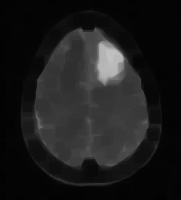

In [ ]:

#Step 3b - apply erosion + dilation
#apply erosion and dilation to show only the part of the image having more intensity - tumor region
#that we want to extract

kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(9,9))
erosion = cv2.morphologyEx(median_filtered, cv2.MORPH_ERODE, kernel)
cv2_imshow(erosion)

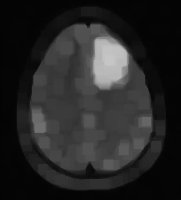

In [ ]:


dilation = cv2.morphologyEx(erosion, cv2.MORPH_DILATE, kernel)
cv2_imshow(dilation)


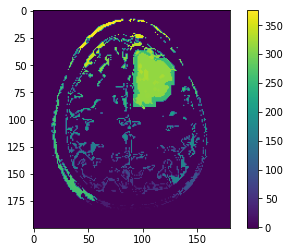

In [ ]:

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
#dist_transform = cv2.distanceTransform(opening, distanceType=cv2.CV_DIST_L2, maskSize=5)

dist_transform = img_sobel.copy()


ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
contours, hierarchy = cv2.findContours(sure_fg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# Creating a numpy array for markers and converting the image to 32 bit using dtype paramter
marker = np.zeros((grayscale_img.shape[0], grayscale_img.shape[1]),dtype = np.int32)

marker = np.int32(sure_fg) + np.int32(sure_bg)

# Marker Labelling
for id in range(len(contours)):
    cv2.drawContours(marker,contours,id,id+2, -1)

marker = marker + 1

##marker[unknown==255] = 0

copy_img = image.copy()

cv2.watershed(copy_img, marker)

imgplt = plt.imshow(marker)
plt.colorbar()
plt.show()

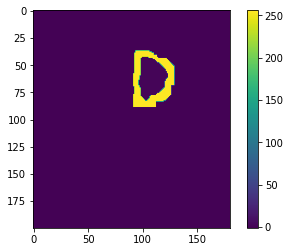

In [ ]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)
#dist_transform = cv2.distanceTransform(opening, distanceType=cv2.CV_DIST_L2, maskSize=5)

dist_transform = erosion.copy()


ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)
contours, hierarchy = cv2.findContours(sure_fg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# Creating a numpy array for markers and converting the image to 32 bit using dtype paramter
marker = np.zeros((erosion.shape[0], erosion.shape[1]),dtype = np.int32)

marker = np.int32(sure_fg) + np.int32(sure_bg)

# Marker Labelling
for id in range(len(contours)):
    cv2.drawContours(marker,contours,id,id+2, -1)

marker = marker + 1

##marker[unknown==255] = 0

copy_img = image.copy()

cv2.watershed(copy_img, marker)

imgplt = plt.imshow(marker)
plt.colorbar()
plt.show()

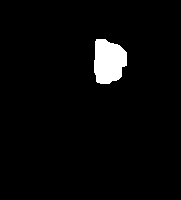

In [ ]:
#Step 4 - apply thresholding
threshold = 160
maxValue = 255

# apply thresholding
new_thresholding = apply_threshold(dilation,  **{"threshold" : 160,
                                                 "pixel_value" : 255,
                                                 "threshold_method" : cv2.THRESH_BINARY})
cv2_imshow(new_thresholding)
